数据来源：http://archive.ics.uci.edu/ml/datasets/Heart+Disease
参考：
  1. https://www.cnblogs.com/pinard/p/6035872.html 调参参考
  2. https://www.kesci.com/home/project/5adf41fecb9a20015508638a sklit数据
  3. 画roc，auc： 
      https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
      http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
      http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
# 评价
from sklearn import metrics
# 交叉验证
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression

from sklearn.datasets import load_iris
from sklearn.metrics import roc_curve, auc

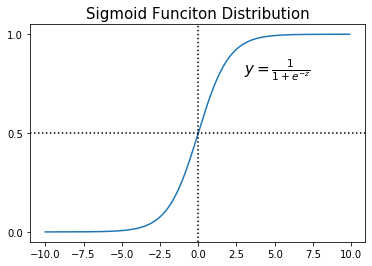

In [2]:
# sigmod函数图：matlibplot居然支持latex
def Sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

x = np.arange(-10, 10, 0.1)
h = Sigmoid(x)  # Sigmoid函数
plt.plot(x, h)
plt.axvline(0.0, ls='dotted', color='k')
plt.axhline(y=0.5, ls='dotted', color='k')
plt.yticks([0.0,  0.5, 1.0])  # y axis label
plt.title(r'Sigmoid Funciton Distribution', fontsize = 15)
plt.text(3,0.8,r'$y = \frac{1}{1+e^{-z}}$', fontsize = 15)
#plt.text(3,0.6,r'$x = wz+b$', fontsize = 18)
plt.show()

In [3]:
# 读取数据
data = pd.read_csv('./heart_disease/processed.cleveland.data')


In [4]:
# 处理异常值
data["ca"] = pd.to_numeric(data["ca"], errors='coerce').fillna(method='ffill')
data["thal"] = pd.to_numeric(data["thal"], errors='coerce').fillna(method='ffill')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age           303 non-null float64
sex           303 non-null float64
cp            303 non-null float64
trestbps      303 non-null float64
chol          303 non-null float64
fbs           303 non-null float64
restecg       303 non-null float64
thalach       303 non-null float64
exang         303 non-null float64
oldpeak       303 non-null float64
slope         303 non-null float64
ca            303 non-null float64
thal          303 non-null float64
predictnum    303 non-null int64
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [5]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,predictnum
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.683168,4.732673,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.944808,1.937215,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


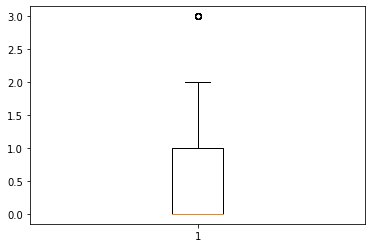

In [6]:
# 特征分析
fig = plt.figure()  # 创建画布
ax = plt.subplot()  # 创建作图区域
ax.boxplot([data["ca"]])
plt.show()


In [7]:
# 计算年龄分布：数值特征
def cal_feature_distribution(df, feature_name, label_name):
    feature_dis = {}
    for idx, row in df.iterrows():
        f_v = row[feature_name]
        f_l = row[label_name]
        if f_v not in feature_dis:
            feature_dis[f_v] = {}
        if f_l not in feature_dis[f_v]:
            feature_dis[f_v][f_l] = 0
        feature_dis[f_v][f_l] += 1
    
    x_res = []
    y_res = []
    z_res = []
    for f_v in feature_dis:
        for f_l in feature_dis[f_v]:
            x_res.append(f_v)
            y_res.append(f_l)
            z_res.append(feature_dis[f_v][f_l])
    return feature_dis, x_res, y_res, z_res

def plot_feature_distribution(df, feature_name, label_name):
    
    age_feature_dis, x_res, y_res, z_res = cal_feature_distribution(df, feature_name, label_name)
    fig = plt.figure()
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
    ax.scatter(x_res, y_res, z_res,marker='o')
    plt.xlabel(feature_name)
    plt.ylabel('label')
    ax.set_zlabel("counter")
    plt.show()


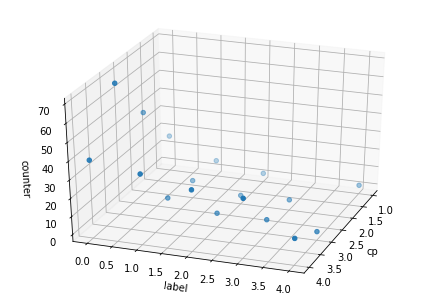

In [8]:
plot_feature_distribution(data, "cp", "predictnum")

In [9]:
# 计算label分布
label_dict = {}
for idx, row in data.iterrows():
    if row["predictnum"] not in label_dict:
        label_dict[row["predictnum"]] = 0
    label_dict[row["predictnum"]] += 1
label_dict

{0.0: 164, 2.0: 36, 1.0: 55, 3.0: 35, 4.0: 13}

In [10]:
set(sorted(data["thal"].to_list()))

{3.0, 6.0, 7.0}

In [11]:
# 处理label：label分为5类0,1,2,3,4,5
for idx,row in data.iterrows():
    data.loc[idx,"label0"] = 0
    data.loc[idx,"label1"] = 0
    data.loc[idx,"label2"] = 0
    data.loc[idx,"label3"] = 0
    data.loc[idx,"label4"] = 0
    if row["predictnum"] == 0:
        data.loc[idx,"label0"] = 1
    elif row["predictnum"] == 1:
        data.loc[idx,"label1"] = 1
    elif row["predictnum"] == 2:
        data.loc[idx,"label2"] = 1
    elif row["predictnum"] == 3:
        data.loc[idx,"label3"] = 1
    elif row["predictnum"] == 4:
        data.loc[idx,"label4"] = 1
    else:
        pass
    
    # 增加而分类标签
    if row["predictnum"] == 0:
        data.loc[idx,"bin_label"] = 0
    else:
        data.loc[idx,"bin_label"] = 1


In [12]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,predictnum,label0,label1,label2,label3,label4,bin_label
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.683168,4.732673,0.937294,0.541254,0.181518,0.118812,0.115512,0.042904,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.944808,1.937215,1.228536,0.499120,0.386085,0.324102,0.320167,0.202977,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
feature_index = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

In [30]:
# 特征
X = data[feature_index].values
# 输出值
y = data[["predictnum"]].values
y_all=data[["predictnum", "label0","label1","label2","label3","label4"]].values

In [31]:
# X[0],X[0,:],X[0, :].reshape(1, -1)

In [32]:
y_all

array([[0., 1., 0., 0., 0., 0.],
       [2., 0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       ...,
       [3., 0., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [17]:
# 高维数据，图上难以显示
#plt.scatter(X["restecg"], X["cp"], marker='o', c=y["predictnum"])
#plt.show()

In [33]:
# 抽样
X_train, X_test, y_train_all, y_test_all = train_test_split(X, y_all, random_state=1)
y_train_all[:,0]

array([3., 1., 1., 0., 0., 0., 2., 0., 0., 3., 2., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 3., 2., 0., 0., 3., 0., 1., 1., 0., 2., 0., 0., 0., 3.,
       2., 3., 0., 0., 0., 0., 1., 2., 0., 0., 0., 2., 1., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 4., 0., 4., 4.,
       0., 0., 1., 0., 3., 4., 0., 0., 3., 0., 0., 0., 2., 4., 1., 1., 0.,
       0., 1., 0., 2., 2., 1., 0., 3., 3., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 1., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 2., 2., 3., 4., 0., 0., 3., 0., 0., 2., 2., 0., 0., 1.,
       2., 1., 0., 2., 1., 0., 3., 2., 3., 3., 0., 1., 0., 2., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 4., 0., 3.,
       1., 0., 1., 0., 0., 3., 3., 2., 3., 1., 0., 3., 4., 0., 0., 0., 2.,
       0., 3., 0., 1., 0., 0., 0., 1., 0., 4., 0., 2., 0., 4., 1., 2., 1.,
       0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 3., 0., 0.,
       0., 0., 0., 1., 3.

In [34]:
# 暂时不用
clf = LogisticRegression(C=1e5, max_iter=50000)
# Create an instance of Logistic Regression Classifier and fit the data.
clf.fit(X_train, np.ravel(y_train_all[:,0]))


LogisticRegression(C=100000.0, max_iter=50000)

In [35]:
X_test

array([[4.30e+01, 1.00e+00, 4.00e+00, 1.10e+02, 2.11e+02, 0.00e+00,
        0.00e+00, 1.61e+02, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        7.00e+00],
       [6.80e+01, 1.00e+00, 3.00e+00, 1.18e+02, 2.77e+02, 0.00e+00,
        0.00e+00, 1.51e+02, 0.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
        7.00e+00],
       [5.90e+01, 1.00e+00, 4.00e+00, 1.38e+02, 2.71e+02, 0.00e+00,
        2.00e+00, 1.82e+02, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        3.00e+00],
       [6.40e+01, 1.00e+00, 4.00e+00, 1.45e+02, 2.12e+02, 0.00e+00,
        2.00e+00, 1.32e+02, 0.00e+00, 2.00e+00, 2.00e+00, 2.00e+00,
        6.00e+00],
       [6.00e+01, 0.00e+00, 4.00e+00, 1.58e+02, 3.05e+02, 0.00e+00,
        2.00e+00, 1.61e+02, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        3.00e+00],
       [4.10e+01, 1.00e+00, 2.00e+00, 1.20e+02, 1.57e+02, 0.00e+00,
        0.00e+00, 1.82e+02, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        3.00e+00],
       [4.20e+01, 1.00e+00, 3.00e+00, 1.30e+02, 1.80e+02, 0.00e+00,
  

In [36]:
# 交叉验证法
#clf = LogisticRegressionCV(cv=5, max_iter=10000, random_state=0).fit(X, np.ravel(y))

In [37]:
# 抽样产出概率：每个类别概率
p_list = clf.predict_proba(X_test[1, :].reshape(1, -1))
# 验证概率和=0
p_list[0][0] + p_list[0][1] + p_list[0][2] + p_list[0][3] + p_list[0][4]

# 预测标记
clf.predict(X[1, :].reshape(1, -1))
# 系数
Sigmoid(np.dot(clf.coef_, X[1, :]) + clf.intercept_)

# clf.predict_proba(X[1, :].reshape(1, -1))[1]相等

# 输出系数
clf.coef_

array([[ 1.08019199e-02, -1.08365828e+00, -4.37251729e-01,
        -1.25932681e-02, -2.94704089e-03,  2.02729202e+00,
        -1.98291162e-01,  1.59416517e-02, -1.09037173e+00,
        -4.07230812e-01, -4.20839193e-01, -1.15859420e+00,
        -2.79702978e-01],
       [-7.55399023e-03,  7.93817511e-01, -4.50195536e-02,
         1.79781118e-03,  5.39956546e-04,  1.20753718e+00,
        -2.05046111e-02, -8.30491139e-03,  1.40153640e-01,
        -2.56581453e-01, -1.17685756e-01, -1.46757116e-01,
        -1.72584364e-01],
       [-1.48529006e-02,  3.43349729e-01,  4.82733421e-01,
         1.67618172e-03,  5.56442510e-03,  2.40451454e+00,
        -4.22841396e-01, -1.28035424e-02,  1.79031171e-01,
         2.03561588e-01,  5.90422212e-02,  2.11541131e-01,
         5.52133035e-02],
       [-2.11433155e-02, -2.15716942e-01,  3.01702917e-02,
         4.98579763e-03,  5.11928595e-04,  2.33067417e+00,
         1.80267489e-01, -1.03447637e-02,  5.04484704e-02,
         2.17122430e-01, -2.16716150e

In [38]:
# 输出所有样例正负概率
y_test_score = clf.predict_proba(X_test[:, :])
y_test_label = y_test_all[:,1:]

In [39]:
# 输出auc
y_test_score.shape,y_test_label.shape

((76, 5), (76, 5))

In [40]:
# 画roc曲线
def cal_roc(y_test, y_score, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test[:,:].ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr,tpr,roc_auc
fpr,tpr,roc_auc = cal_roc(y_test_label, y_test_score,5)

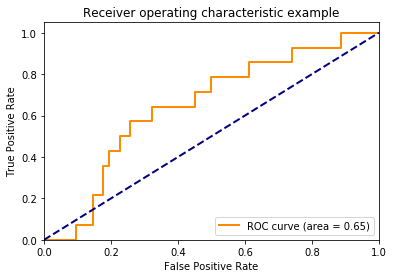

In [41]:
plt.figure()
label_idx = 1
lw = 2
plt.plot(fpr[label_idx], tpr[label_idx], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[label_idx])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [43]:
clf = LogisticRegressionCV(cv=5,max_iter=10000,random_state=0).fit(X2, y2)


NameError: name 'X2' is not defined

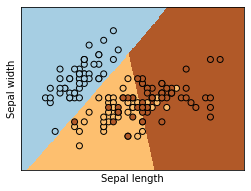

In [28]:
# sklearn上例子
# np_c_：按行拼接矩阵
# ravel:行转列
#
iris = load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

logreg = LogisticRegression(C=1e5)
# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X, Y)
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # 网格大小，step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)


plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()